# Second order stochastic methods for CryoEM

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [25]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.algorithm import oasis, oasis_adaptive
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [3]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles: 105519
load_data: data loaded, time:  73.79 sec.


In [4]:
out_dir = out_dir = '../data/out_dev/'

In [5]:
nx0 = imgs0.shape[1]
nx_crop = 128
N = 80000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

imgs0.shape = (105519, 320, 320)
pixel_size0.shape = (105519,)
angles0.shape = (105519, 3)
shifts0.shape = (105519, 2)
ctf_params0.shape = (105519, 9)
Shuffle = False
N = 80000
Taking FFT of the images:
Batch 1/10  22.09 sec.
Batch 2/10  22.39 sec.
Batch 3/10  21.86 sec.
Batch 4/10  21.89 sec.
Batch 5/10  24.41 sec.
Batch 6/10  24.43 sec.
Batch 7/10  23.54 sec.
Batch 8/10  24.21 sec.
Batch 9/10  23.87 sec.
Batch 10/10  23.23 sec.
FFT done. Time:  283.61 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 1.28000000e+02]
Vectorised imgs_f.shape = (80000, 16384)
Mask radius = 0.1502862595419847
Estimating the noise using the 48 x 48 corners of the first 1000 images.
Estimating pixel-wise noise...done.
Averaging radially...done.
Noise estimation done. Time:  20.82 sec.


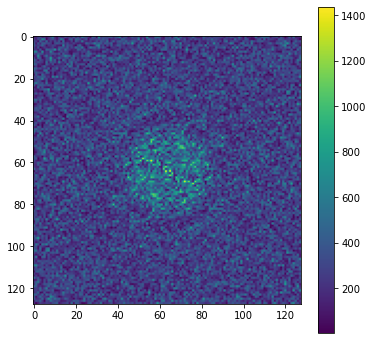

In [6]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[2135].reshape([128,128]))));plt.colorbar()

In [7]:
del(imgs0)

### Only volume reconstruction for now - SGD vs OASIS

Obervations:

* The loss and grad don't tell us anything about convergence. The loss is about the same after only 100 iterations and after 10 epochs (of 781 iters each), and yet the result is different

In [8]:
# Apply mask to images
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [9]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [10]:
alpha = 1e-9

slice_obj = Slice(x_grid)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

Use the same datasets, loss, grad, hvp, x0, D0 for SGD and OASIS

In [16]:
idxrand = np.random.permutation(N)
idx1 = idxrand[:N//2]
idx2 = idxrand[N//2:]

In [29]:
grad_func1, loss_func1, hvp_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], sigma_noise)
grad_func2, loss_func2, hvp_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [31]:
iters = 2000
batch_sz = 100
key, *subkeys = random.split(key, 2*iters+1)

zD01z = np.zeros([nx,nx,nx])
zD02z = np.zeros([nx,nx,nx])

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], [nx,nx,nx], dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N//2)[:batch_sz]
    
    zD01z += z * hvp_func1(x0, z, idx)
    zD02z += z * hvp_func1(x0, z, idx)
    
D01 = jnp.array(zD01z/iters)
D02 = jnp.array(zD02z/iters)

100%|██████████| 2000/2000 [02:41<00:00, 12.38it/s]


#### SGD

In [32]:
N_epochs = 2
batch_size = 32
step_size = 1e-2 #1000000 # 1e-3

In [33]:
v_rec1, loss_rec1, grad_rec1 = sgd(grad_func1, loss_func1, N//2, x0, step_size, N_epochs, batch_size, P = 1/D01, verbose=True, iter_display=1)


Epoch 1/2 

100%|██████████| 1250/1250 [00:54<00:00, 22.98it/s, grad=2.895e-04, loss=5.908e+03]


  |Grad| = 2.749e-04
  Loss = 5.906e+03
Epoch 2/2 

100%|██████████| 1250/1250 [00:45<00:00, 27.46it/s, grad=2.417e-04, loss=5.902e+03]


  |Grad| = 2.741e-04
  Loss = 5.907e+03


In [34]:
v_rec2, loss_rec2, grad_rec2 = sgd(grad_func2, loss_func2, N//2, x0, step_size, N_epochs, batch_size, P=1/D02, verbose=True, iter_display=1)


Epoch 1/2 

100%|██████████| 1250/1250 [00:45<00:00, 27.35it/s, grad=2.653e-04, loss=5.937e+03]


  |Grad| = 2.743e-04
  Loss = 5.908e+03
Epoch 2/2 

100%|██████████| 1250/1250 [00:46<00:00, 27.10it/s, grad=2.651e-04, loss=5.928e+03]


  |Grad| = 2.733e-04
  Loss = 5.909e+03


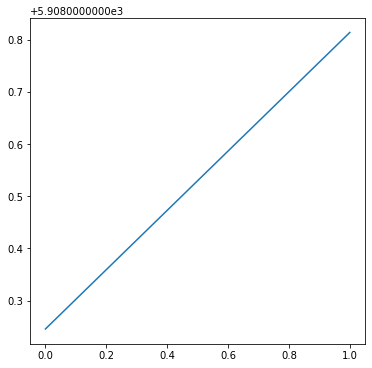

In [35]:
plt.plot(loss_rec2)

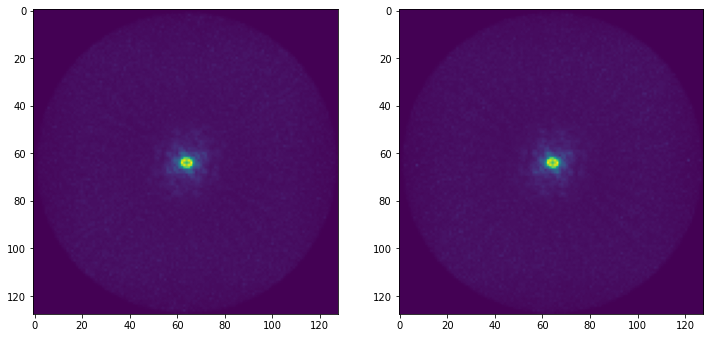

In [36]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec1))); #plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec2))); #plt.colorbar()

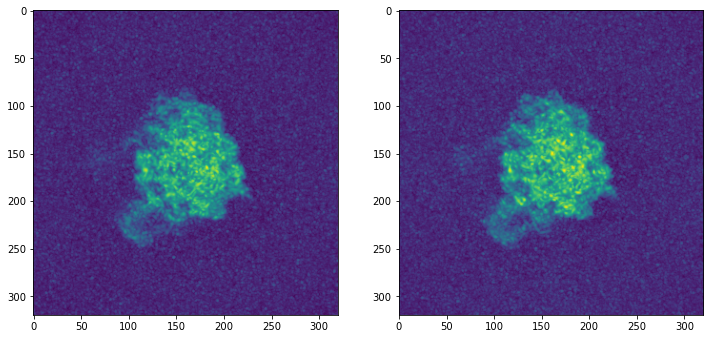

In [37]:
v_rec_l1, _ = rescale_larger_grid(v_rec1, x_grid, nx0)
vr_sgd1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l1)))

v_rec_l2, _ = rescale_larger_grid(v_rec2, x_grid, nx0)
vr_sgd2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l2)))

plt.subplot(1,2,1)
mip_z(vr_sgd1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_sgd2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [38]:
with mrcfile.new(f"{out_dir}/v_rec_sgd1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_sgd2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd2.astype(np.float32))   

Text(0.5, 1.0, 'FSC')

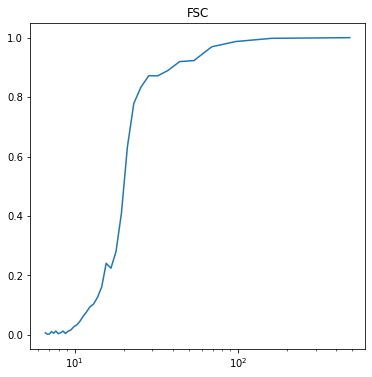

In [39]:
res, fsc, shell_points = calc_fsc(v_rec1, v_rec2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc)
plt.title("FSC")

#### OASIS

### Something is wrong here:

* The OASIS reconstruction is flipped compared to the SGD one - why
* Also the OASIS rec with fixed rate should be the same as SGD with D0 preconditioner, so the loss and results should be the same. What's wrong? For some reason the object stays very low resolution
* Work with a dataset with no heterogeneity

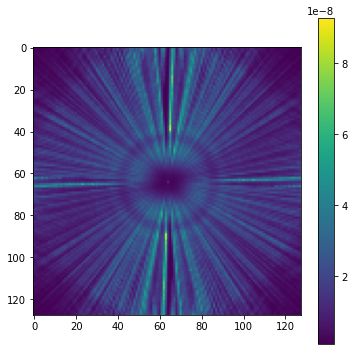

In [49]:
plt.imshow(jnp.fft.fftshift(jnp.abs(D01[0,:,:]))); plt.colorbar()

In [50]:
N_epoch = 2
beta2 = 1 #0.99
eta0 = 1e-4 #0.0001 #0.1/0.001/0.01/0.15
batch_size = 32
alpha = 1e-15 #0.1 # 0.01

key, subkey = random.split(key)

In [52]:
v_rec_o1, loss_o1 = oasis(subkey, loss_func1, grad_func1, hvp_func1, x0, eta0, D01, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


Epoch 1/2


100%|██████████| 1250/1250 [01:18<00:00, 15.98it/s, loss=6.277e+03]


  Loss =  6.191e+03
Epoch 2/2


100%|██████████| 1250/1250 [01:15<00:00, 16.48it/s, loss=6.507e+03]


  Loss =  6.216e+03


In [ ]:
v_rec_oa1, loss_oa1 = oasis_adaptive(subkey, loss_func1, grad_func1, hvp_func1, x0, eta0, D01, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


In [54]:
v_rec_o2, loss_o2 = oasis(subkey, loss_func2, grad_func2, hvp_func2, x0, eta0, D02, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


Epoch 1/2


100%|██████████| 1250/1250 [01:18<00:00, 15.98it/s, loss=6.163e+03]


  Loss =  6.194e+03
Epoch 2/2


100%|██████████| 1250/1250 [01:16<00:00, 16.27it/s, loss=6.244e+03]


  Loss =  6.219e+03


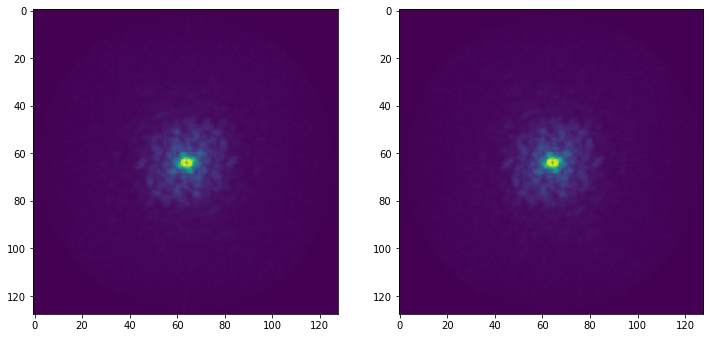

In [55]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec_o1))); #plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec_o2))); #plt.colorbar()

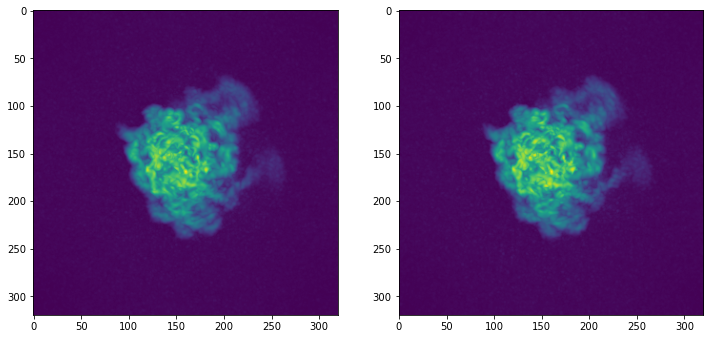

In [56]:
v_rec_ol1, _ = rescale_larger_grid(v_rec_o1, x_grid, nx0)
vr_o1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol1)))

v_rec_ol2, _ = rescale_larger_grid(v_rec_o2, x_grid, nx0)
vr_o2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol2)))

plt.subplot(1,2,1)
mip_z(vr_o1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_o2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [57]:
with mrcfile.new(f"{out_dir}/v_rec_o1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_o2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o2.astype(np.float32))   

Text(0.5, 1.0, 'FSC')

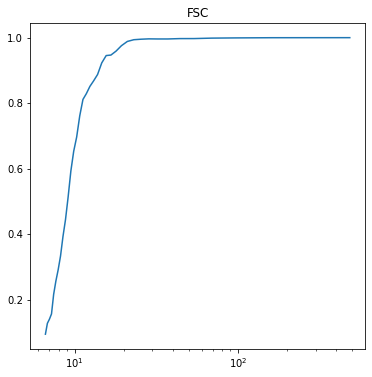

In [58]:
res, fsc, shell_points = calc_fsc(v_rec_o1, v_rec_o2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc)
plt.title("FSC")

In [59]:
fsc

DeviceArray([1.        , 0.99986564, 0.99926702, 0.99858197, 0.99722344,
             0.99714394, 0.99603399, 0.99601492, 0.99634162, 0.99524138,
             0.99373447, 0.98846029, 0.97547604, 0.95872193, 0.94685577,
             0.94532038, 0.92284789, 0.88741751, 0.86808467, 0.85112075,
             0.82891144, 0.81139336, 0.76110082, 0.69629806, 0.65292081,
             0.59252068, 0.51331062, 0.44423599, 0.39241772, 0.33295365,
             0.2907985 , 0.25630371, 0.2158737 , 0.15599522, 0.13989851,
             0.12735447, 0.09417734], dtype=float64)

In [67]:
fsc[26]

DeviceArray(0.51331062, dtype=float64)

In [70]:
fsc[27]

DeviceArray(0.44423599, dtype=float64)

In [69]:
res_angs[26]

DeviceArray(9.13302765, dtype=float64)

In [71]:
res_angs[27]

DeviceArray(8.80091756, dtype=float64)

### Newton's method vs GD vs CG

#### GD - a pain to tune 

In [ ]:
Ngd = 1000

N_epochs = 200
batch_size = Ngd
step_size = 10000 # 1e-3

idx = np.arange(Ngd)

grad_func, loss_func = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [ ]:
v_rec_gd, loss_rec_gd, grad_rec_gd = sgd(grad_func, loss_func1, Ngd, x0, step_size, N_epochs, batch_size, verbose=True, iter_display=10)


In [ ]:
plt.plot(loss_rec_gd)

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

In [3]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

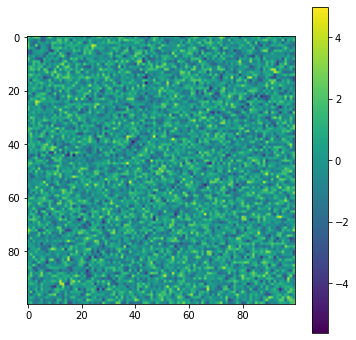

In [4]:
key, subkey = random.split(key)

A = random.normal(subkey, (n,n))
A = A.T + A

plt.imshow(A); plt.colorbar()

In [5]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

#z * A @ z 

In [6]:
zAz = jax.vmap(lambda zi : zi * (A @ zi))(z)
#plt.imshow(zAz)

In [7]:
d = np.zeros((iters, n))
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i-1] + zAz[i]
    
for i in range(1, iters):
    d[i] = d[i]/(i+1)

In [8]:
err = jnp.mean((d - jnp.diag(A))**2, axis=1)

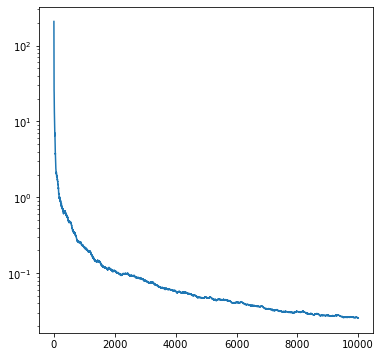

In [9]:
plt.semilogy(err)

#### Hessian-vector product in JaX

In [10]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [11]:
b = A @ x0 
f = lambda x : jnp.mean((A @ x - b)**2)

In [12]:
f(x0)

DeviceArray(0., dtype=float64)

In [13]:
from jax import jvp, grad

# Naive
def hvp0(f, x, v):
    return grad(lambda x : jnp.vdot(grad(f)(x), v))(x)

# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [14]:
t0 = time.time()
v1 = hvp0(f, x, v).block_until_ready()
print(time.time()-t0)

t0 = time.time()
v2 = hvp(f, (x,), (v,)).block_until_ready()
print(time.time()-t0)

jnp.sum(jnp.abs(v1-v2))

1.0572991371154785
0.5253634452819824


DeviceArray(0., dtype=float64)

#### Toy problem

Condition number =  3.33e+05


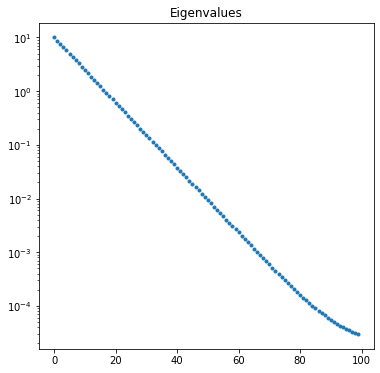

In [15]:
key, *subkey = random.split(key, 4)

x_gt = random.normal(subkey[0], (n,))

A = np.random.normal(size = (n,n))
A = A.T @ A
_, v = jnp.linalg.eigh(A)
d = jnp.flip(jnp.logspace(-5,1,n)) 
d = d + jnp.abs(jnp.min(d)*2)
A = v.T @ jnp.diag(d) @ v

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort(evals))


assert(jnp.sum(evals < 0) == 0)
#assert(jnp.max(jnp.abs(A.T - A)) == 0)
#assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)


plt.semilogy(evals, '.')
plt.title("Eigenvalues")
print(f"Condition number = {evals[0]/evals[n-1] : .2e}")

In [16]:
sig_noise = 1
lam = 0.1

b = A @ x_gt  + np.random.normal(size=(n,)) * sig_noise

F = jax.jit(lambda x : jnp.sum((A @ x - b)**2) + lam * jnp.mean(x**2))
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.jit(jax.grad(F))
hessianF = jax.hessian(F)

hvpF = jax.jit(lambda x, v : hvp(F, (x,), (v,)))

print(f"gradF(x_gt) = {gradF(x_gt)}")
print(f"hessianF(x_gt) = {hessianF(x_gt)}")


f(x_gt + 1) = 301.1391571590309
f(x_gt) = 107.07820462257885
gradF(x_gt) = [ -5.01176215  -3.19295776   4.38284833   3.03826829   0.51048206
 -11.29038029  -5.71398536  -2.89038256   0.30750391   8.23073093
   6.89843741  -2.54453137  -2.75769219  -1.04149097   0.11320624
   3.176941    -1.87840671  -2.28160095   0.50864384  -1.62611701
  -2.29459047  -7.37370735  -5.00351259  12.03330879  -1.37898891
   0.26209334  -1.92634377  -7.74453309   8.07554994  -1.1604493
  -5.20793143  -0.39378773  -3.19657175   0.25284267   3.39963725
   4.83641034   7.18668738  -8.34815662  -8.53771733   2.93776962
   2.93700138  -6.27093634  -0.4773437   -4.03588155  -5.74865765
   2.31805797   7.81162977   2.18681517  -3.45243943  -5.26955073
  -0.37363242   1.40708684   4.81341148   0.45228129 -13.4532839
   6.73378548   4.69890857  -6.95418076  -0.79674398  -1.72019824
   8.16056472   5.8481844   -6.27543988   0.01769053  -8.30813488
   8.85341814   1.67454482  -2.19254504   0.35352926   9.164608
  -0.

In [17]:
def gd(F, gradF, eta, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        w1 = w0 - eta * gradF(w0)
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

def newton(F, gradF, hessianF, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        G = gradF(w0)
        H = hessianF(w0)
        
        w1 = w0 - jnp.linalg.inv(H) @ G
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

In [18]:
N_iter = 10000
eta = 1e-3 #0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display = 200)

Iter 200: loss = 125.93963936491771
Iter 400: loss = 108.4476397428748
Iter 600: loss = 99.21487115191644
Iter 800: loss = 93.31494569011193
Iter 1000: loss = 89.20490179381211
Iter 1200: loss = 86.17329083660097
Iter 1400: loss = 83.83438747726865
Iter 1600: loss = 81.96256922578914
Iter 1800: loss = 80.41949645007598
Iter 2000: loss = 79.11707273942552
Iter 2200: loss = 77.99717576228404
Iter 2400: loss = 77.02008681473804
Iter 2600: loss = 76.15769556224957
Iter 2800: loss = 75.38941954013885
Iter 3000: loss = 74.69970403651295
Iter 3200: loss = 74.07645858205777
Iter 3400: loss = 73.51005710871225
Iter 3600: loss = 72.99268246139788
Iter 3800: loss = 72.51788469705606
Iter 4000: loss = 72.0802745566556
Iter 4200: loss = 71.67530422095719
Iter 4400: loss = 71.29910579602705
Iter 4600: loss = 70.94836901212446
Iter 4800: loss = 70.62024632661775
Iter 5000: loss = 70.31227774085187
Iter 5200: loss = 70.02233020293029
Iter 5400: loss = 69.74854808607752
Iter 5600: loss = 69.48931227216

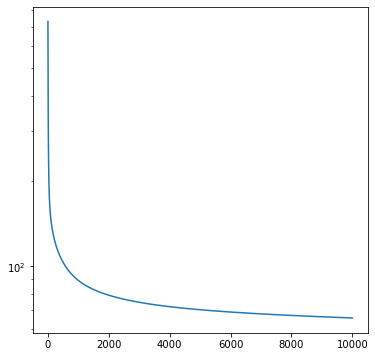

In [19]:
plt.semilogy(loss_gd)

In [20]:
N_iter = 10

x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

Iter 1: loss = 51.10529955096387
Iter 2: loss = 51.10529955096389
Iter 3: loss = 51.10529955096385
Iter 4: loss = 51.10529955096389
Iter 5: loss = 51.10529955096388
Iter 6: loss = 51.10529955096392
Iter 7: loss = 51.105299550963885
Iter 8: loss = 51.1052995509639
Iter 9: loss = 51.1052995509639
Iter 10: loss = 51.10529955096387


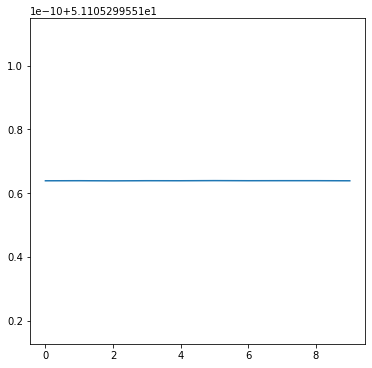

In [21]:
plt.plot(loss_n)

In [22]:
N_iter = 10000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = jax.jit(lambda vv : jnp.conj(gradF(vv)) + Ab)

x_cg, kk = cg(AA, Ab, x0, N_iter, verbose=True)

  cg iter 0 ||r|| = 157.7116927177899
  cg iter 200 ||r|| = 2.4058385340095145e-05
  cg iter 400 ||r|| = 2.502612569887334e-10
  cg iter 600 ||r|| = 6.300644849526012e-12
  cg iter 800 ||r|| = 7.872607309665232e-13
  cg iter 1000 ||r|| = 8.553509679998009e-13
  cg iter 1200 ||r|| = 3.5981339122883654e-13
  cg iter 1400 ||r|| = 2.83552665199775e-13
  cg iter 1600 ||r|| = 4.0888058347976263e-13
  cg iter 1800 ||r|| = 2.747957489423967e-13
  cg iter 2000 ||r|| = 2.358550537094438e-13
  cg iter 2200 ||r|| = 1.6575225949135806e-13
  cg iter 2400 ||r|| = 2.238128093491841e-13
  cg iter 2600 ||r|| = 2.91222506739589e-13
  cg iter 2800 ||r|| = 1.4109424697878818e-13
  cg iter 3000 ||r|| = 1.8997211326817998e-13
  cg iter 3200 ||r|| = 2.632586273974735e-13
  cg iter 3400 ||r|| = 2.580861820029916e-13
  cg iter 3600 ||r|| = 2.0191362470658365e-13
  cg iter 3800 ||r|| = 1.3706236751424303e-13
  cg iter 4000 ||r|| = 2.3631548288061776e-13
  cg iter 4200 ||r|| = 1.523500343290996e-13
  cg iter 4400

In [23]:
F(x_cg)

DeviceArray(51.10529955, dtype=float64)

#### OASIS

In [24]:
Fidx = jax.jit(lambda x, idx : F(x))
gradFidx = jax.jit(lambda x, idx : jax.grad(F)(x))
hvpFidx = jax.jit(lambda x, v, idx : hvp(F, (x,), (v,)))

In [29]:
# Estimating D0

iters = 10000
key, *subkeys = random.split(key, iters+1)
zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[i], (n,), dtype=x0.dtype)
    
    zD0z += z * hvpFidx(x0, z, 1)
    
D0 = jnp.array(zD0z/iters)

D0exact = jnp.diag(hessianF(x0)) # Cheating a bit


100%|██████████| 10000/10000 [00:03<00:00, 3083.82it/s]


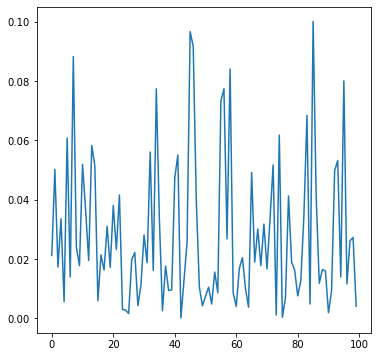

In [30]:
plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [31]:
N_iter = 10000
beta2 = 0.99
eta = 0.01 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display = 500)


Epoch 500/10000


100%|██████████| 1/1 [00:00<00:00, 172.84it/s, loss=9.478e+01]

  Loss =  9.478e+01


Epoch 1000/10000


100%|██████████| 1/1 [00:00<00:00, 204.52it/s, loss=8.303e+01]

  Loss =  8.303e+01


Epoch 1500/10000


100%|██████████| 1/1 [00:00<00:00, 110.55it/s, loss=7.777e+01]

  Loss =  7.777e+01


Epoch 2000/10000


100%|██████████| 1/1 [00:00<00:00, 177.95it/s, loss=7.465e+01]

  Loss =  7.465e+01


Epoch 2500/10000


100%|██████████| 1/1 [00:00<00:00, 142.05it/s, loss=7.254e+01]

  Loss =  7.254e+01


Epoch 3000/10000


100%|██████████| 1/1 [00:00<00:00, 189.08it/s, loss=7.102e+01]

  Loss =  7.102e+01


Epoch 3500/10000


100%|██████████| 1/1 [00:00<00:00, 189.51it/s, loss=6.985e+01]

  Loss =  6.985e+01


Epoch 4000/10000


100%|██████████| 1/1 [00:00<00:00, 228.95it/s, loss=6.891e+01]

  Loss =  6.891e+01


Epoch 4500/10000


100%|██████████| 1/1 [00:00<00:00, 162.84it/s, loss=6.814e+01]

  Loss =  6.814e+01


Epoch 5000/10000


100%|██████████| 1/1 [00:00<00:00, 254.82it/s, loss=6.747e+01]

  Loss =  6.747e+01


Epoch 5500/10000


100%|██████████| 1/1 [00:00<00:00, 146.88it/s, loss=6.689e+01]

  Loss =  6.689e+01


Epoch 6000/10000


100%|██████████| 1/1 [00:00<00:00, 152.75it/s, loss=6.637e+01]

  Loss =  6.637e+01


Epoch 6500/10000


100%|██████████| 1/1 [00:00<00:00, 165.27it/s, loss=6.590e+01]

  Loss =  6.590e+01


Epoch 7000/10000


100%|██████████| 1/1 [00:00<00:00, 321.97it/s, loss=6.547e+01]

  Loss =  6.547e+01


Epoch 7500/10000


100%|██████████| 1/1 [00:00<00:00, 168.30it/s, loss=6.507e+01]

  Loss =  6.507e+01


Epoch 8000/10000


100%|██████████| 1/1 [00:00<00:00, 206.14it/s, loss=6.470e+01]

  Loss =  6.470e+01


Epoch 8500/10000


100%|██████████| 1/1 [00:00<00:00, 186.51it/s, loss=6.436e+01]

  Loss =  6.436e+01


Epoch 9000/10000


100%|██████████| 1/1 [00:00<00:00, 189.77it/s, loss=6.403e+01]

  Loss =  6.403e+01


Epoch 9500/10000


100%|██████████| 1/1 [00:00<00:00, 126.27it/s, loss=6.372e+01]

  Loss =  6.372e+01


Epoch 10000/10000


100%|██████████| 1/1 [00:00<00:00, 187.16it/s, loss=6.343e+01]

  Loss =  6.343e+01


In [32]:
N_iter = 10000
beta2 = 0.99
eta0 = 0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta0, D0, beta2, alpha, N_iter, iter_display = 500)


Epoch 500/10000


100%|██████████| 1/1 [00:00<00:00, 121.32it/s, loss=6.523e+01]

  Loss =  6.523e+01


Epoch 1000/10000


100%|██████████| 1/1 [00:00<00:00, 133.21it/s, loss=6.112e+01]

  Loss =  6.112e+01


Epoch 1500/10000


100%|██████████| 1/1 [00:00<00:00, 172.72it/s, loss=5.884e+01]

  Loss =  5.884e+01


Epoch 2000/10000


100%|██████████| 1/1 [00:00<00:00, 130.37it/s, loss=5.733e+01]

  Loss =  5.733e+01


Epoch 2500/10000


100%|██████████| 1/1 [00:00<00:00, 198.16it/s, loss=5.625e+01]

  Loss =  5.625e+01


Epoch 3000/10000


100%|██████████| 1/1 [00:00<00:00, 195.37it/s, loss=5.545e+01]

  Loss =  5.545e+01


Epoch 3500/10000


100%|██████████| 1/1 [00:00<00:00, 119.76it/s, loss=5.484e+01]

  Loss =  5.484e+01


Epoch 4000/10000


100%|██████████| 1/1 [00:00<00:00, 157.86it/s, loss=5.434e+01]

  Loss =  5.434e+01


Epoch 4500/10000


100%|██████████| 1/1 [00:00<00:00, 98.58it/s, loss=5.395e+01]

  Loss =  5.395e+01


Epoch 5000/10000


100%|██████████| 1/1 [00:00<00:00, 134.92it/s, loss=5.362e+01]

  Loss =  5.362e+01


Epoch 5500/10000


100%|██████████| 1/1 [00:00<00:00, 117.19it/s, loss=5.335e+01]

  Loss =  5.335e+01


Epoch 6000/10000


100%|██████████| 1/1 [00:00<00:00, 142.76it/s, loss=5.313e+01]

  Loss =  5.313e+01


Epoch 6500/10000


100%|██████████| 1/1 [00:00<00:00, 95.08it/s, loss=5.294e+01]

  Loss =  5.294e+01


Epoch 7000/10000


100%|██████████| 1/1 [00:00<00:00, 139.96it/s, loss=5.278e+01]

  Loss =  5.278e+01


Epoch 7500/10000


100%|██████████| 1/1 [00:00<00:00, 120.99it/s, loss=5.264e+01]

  Loss =  5.264e+01


Epoch 8000/10000


100%|██████████| 1/1 [00:00<00:00, 88.92it/s, loss=5.252e+01]

  Loss =  5.252e+01


Epoch 8500/10000


100%|██████████| 1/1 [00:00<00:00, 226.69it/s, loss=5.241e+01]

  Loss =  5.241e+01


Epoch 9000/10000


100%|██████████| 1/1 [00:00<00:00, 191.25it/s, loss=5.231e+01]

  Loss =  5.231e+01


Epoch 9500/10000


100%|██████████| 1/1 [00:00<00:00, 111.32it/s, loss=5.223e+01]

  Loss =  5.223e+01


Epoch 10000/10000


100%|██████████| 1/1 [00:00<00:00, 131.05it/s, loss=5.215e+01]

  Loss =  5.215e+01


17.334825372149133
17.33482537227696
4.243038090581028
5.820156194706069
16.452618668691965


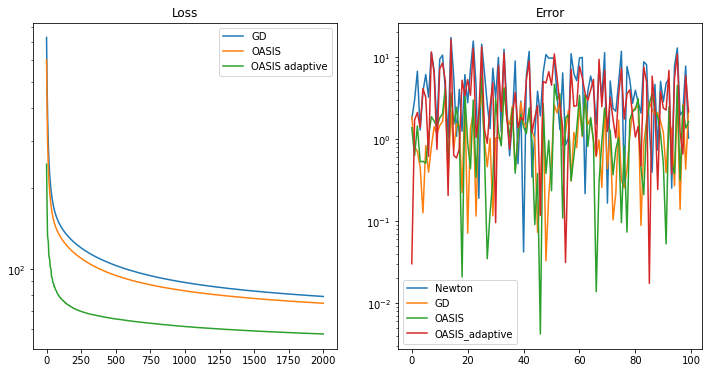

In [34]:
print(jnp.max(jnp.abs(x_gt-x_n)))
print(jnp.max(jnp.abs(x_gt-x_cg)))
print(jnp.max(jnp.abs(x_gt-x_gd)))
print(jnp.max(jnp.abs(x_gt-x_o)))
print(jnp.max(jnp.abs(x_gt-x_oa)))

plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)

nn0 = 0
nn1 = 2000
#plt.semilogy(loss_n[nn0:nn1])
plt.semilogy(loss_gd[nn0:nn1])
plt.semilogy(loss_o[nn0:nn1])
plt.semilogy(loss_oa[nn0:nn1])
#plt.legend(["Newton", "GD", "OASIS", "OASIS adaptive"])
plt.legend(["GD", "OASIS", "OASIS adaptive"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt-x_gd))
plt.semilogy(jnp.abs(x_gt-x_o))
plt.semilogy(jnp.abs(x_gt-x_oa))
plt.legend(["Newton", "GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6, 6

### Stochastic - sum of operators

In [35]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

Generate $N$ operators to create a loss function to do SGD/OASIS on:

In [36]:
sig_noise = 10
lam = 0.1

In [37]:
n = 100
N = 1000

x_gt = np.random.normal(size=(n,))

ops = []
b = []
for i in range(N):
    A = np.random.normal(size=(n,n))
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)
    
    d = jnp.flip(jnp.logspace(-5,4,n)) + np.random.normal(size=(n,))*10 
    d = d + jnp.abs(jnp.min(d)*2)
                 
    A = v.T @ jnp.diag(d) @ v
    ops.append(A)
    
    bn = A @ x_gt + np.random.normal(size=(n,)) * sig_noise
    b.append(bn)
    
    #print(jnp.mean((A@x_gt - bn)**2))
    
ops = jnp.array(ops)
b = jnp.array(b)

In [38]:
w, _ = jnp.linalg.eigh(A)
w = jnp.flip(jnp.sort(w))
print(f"{jnp.max(w)/jnp.min(w) : .2e}")

 4.71e+02


In [39]:
def loss_term(x, A, b):
    return 1/2 * jnp.mean((A@x - b)**2) + lam * jnp.mean(x**2)

def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0))(x, ops, b))

def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)

def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y : grad_loss_func(y, ops, b), (x,), (v,))[1]

In [40]:
idx = np.random.permutation(N)[:N//3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

50.26766797418893
50.034221266047766
(100,)
(100,)
(100,)
(100,)


In [41]:
hessianF = lambda x : jax.hessian(loss_func)(x, ops, b)

Fidx = jax.jit(lambda x, idx : loss_func(x, ops[idx], b[idx]))
gradFidx = jax.jit(lambda x, idx : grad_loss_func(x, ops[idx], b[idx]))
hvpFidx = jax.jit(lambda x, v, idx : hvp_loss_func(x, v, ops[idx], b[idx]))
x0 = jnp.array(np.random.randn(n))

In [42]:
Fidx(x_gt, jnp.arange(N))

DeviceArray(50.03422127, dtype=float64)

100%|██████████| 10000/10000 [00:20<00:00, 485.04it/s]


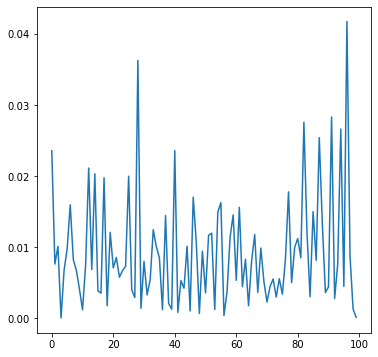

In [57]:
#D0 = jnp.ones((nx,nx,nx))  #<--- not very good

iters = 10000
batch_sz = 32
key, *subkeys = random.split(key, 2*iters+1)

zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], (n,), dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N)[:batch_sz]
    
    zD0z += z * hvpFidx(x0, z, idx)
    
D0 = jnp.array(zD0z/iters)

D0exact = jnp.diag(hessianF(x0)) # Cheating a bit

plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [58]:
N_epoch = 20
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


Epoch 1/20


100%|██████████| 50/50 [00:03<00:00, 15.65it/s, loss=4.160e+02]


  Loss =  1.994e+05
Epoch 2/20


100%|██████████| 50/50 [00:00<00:00, 176.84it/s, loss=5.247e+01]


  Loss =  1.011e+02
Epoch 3/20


100%|██████████| 50/50 [00:00<00:00, 177.52it/s, loss=5.028e+01]


  Loss =  4.971e+01
Epoch 4/20


100%|██████████| 50/50 [00:00<00:00, 180.55it/s, loss=4.973e+01]


  Loss =  4.968e+01
Epoch 5/20


100%|██████████| 50/50 [00:00<00:00, 194.26it/s, loss=4.773e+01]


  Loss =  4.968e+01
Epoch 6/20


100%|██████████| 50/50 [00:00<00:00, 184.12it/s, loss=5.094e+01]


  Loss =  4.966e+01
Epoch 7/20


100%|██████████| 50/50 [00:00<00:00, 190.33it/s, loss=4.902e+01]


  Loss =  4.968e+01
Epoch 8/20


100%|██████████| 50/50 [00:00<00:00, 175.87it/s, loss=5.020e+01]


  Loss =  4.966e+01
Epoch 9/20


100%|██████████| 50/50 [00:00<00:00, 179.16it/s, loss=5.078e+01]


  Loss =  4.966e+01
Epoch 10/20


100%|██████████| 50/50 [00:00<00:00, 182.43it/s, loss=5.031e+01]


  Loss =  4.966e+01
Epoch 11/20


100%|██████████| 50/50 [00:00<00:00, 176.70it/s, loss=4.929e+01]


  Loss =  4.969e+01
Epoch 12/20


100%|██████████| 50/50 [00:00<00:00, 187.81it/s, loss=4.930e+01]


  Loss =  4.967e+01
Epoch 13/20


100%|██████████| 50/50 [00:00<00:00, 178.01it/s, loss=4.882e+01]


  Loss =  4.968e+01
Epoch 14/20


100%|██████████| 50/50 [00:00<00:00, 174.67it/s, loss=4.884e+01]


  Loss =  4.967e+01
Epoch 15/20


100%|██████████| 50/50 [00:00<00:00, 161.40it/s, loss=5.082e+01]


  Loss =  4.966e+01
Epoch 16/20


100%|██████████| 50/50 [00:00<00:00, 181.63it/s, loss=5.064e+01]


  Loss =  4.967e+01
Epoch 17/20


100%|██████████| 50/50 [00:00<00:00, 180.83it/s, loss=4.787e+01]


  Loss =  4.966e+01
Epoch 18/20


100%|██████████| 50/50 [00:00<00:00, 174.06it/s, loss=4.980e+01]


  Loss =  4.967e+01
Epoch 19/20


100%|██████████| 50/50 [00:00<00:00, 195.62it/s, loss=5.184e+01]


  Loss =  4.967e+01
Epoch 20/20


100%|██████████| 50/50 [00:00<00:00, 177.28it/s, loss=5.181e+01]


  Loss =  4.968e+01


In [59]:
N_epoch = 20
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


Epoch 1/20


100%|██████████| 50/50 [00:00<00:00, 131.37it/s, loss=7.095e+01]


  Loss =  1.475e+05
Epoch 2/20


100%|██████████| 50/50 [00:00<00:00, 145.17it/s, loss=5.107e+01]


  Loss =  5.100e+01
Epoch 3/20


100%|██████████| 50/50 [00:00<00:00, 145.66it/s, loss=4.964e+01]


  Loss =  4.963e+01
Epoch 4/20


100%|██████████| 50/50 [00:00<00:00, 133.66it/s, loss=4.754e+01]


  Loss =  4.967e+01
Epoch 5/20


100%|██████████| 50/50 [00:00<00:00, 137.12it/s, loss=5.001e+01]


  Loss =  4.964e+01
Epoch 6/20


100%|██████████| 50/50 [00:00<00:00, 138.76it/s, loss=4.917e+01]


  Loss =  4.970e+01
Epoch 7/20


100%|██████████| 50/50 [00:00<00:00, 134.08it/s, loss=4.914e+01]


  Loss =  4.965e+01
Epoch 8/20


100%|██████████| 50/50 [00:00<00:00, 137.61it/s, loss=4.872e+01]


  Loss =  4.961e+01
Epoch 9/20


100%|██████████| 50/50 [00:00<00:00, 153.36it/s, loss=4.844e+01]


  Loss =  4.967e+01
Epoch 10/20


100%|██████████| 50/50 [00:00<00:00, 146.80it/s, loss=4.951e+01]


  Loss =  4.967e+01
Epoch 11/20


100%|██████████| 50/50 [00:00<00:00, 149.07it/s, loss=4.933e+01]


  Loss =  4.964e+01
Epoch 12/20


100%|██████████| 50/50 [00:00<00:00, 149.12it/s, loss=4.890e+01]


  Loss =  4.968e+01
Epoch 13/20


100%|██████████| 50/50 [00:00<00:00, 137.49it/s, loss=4.657e+01]


  Loss =  4.963e+01
Epoch 14/20


100%|██████████| 50/50 [00:00<00:00, 139.19it/s, loss=4.685e+01]


  Loss =  4.972e+01
Epoch 15/20


100%|██████████| 50/50 [00:00<00:00, 140.14it/s, loss=5.112e+01]


  Loss =  4.963e+01
Epoch 16/20


100%|██████████| 50/50 [00:00<00:00, 137.47it/s, loss=5.112e+01]


  Loss =  4.967e+01
Epoch 17/20


100%|██████████| 50/50 [00:00<00:00, 144.57it/s, loss=4.711e+01]


  Loss =  4.966e+01
Epoch 18/20


100%|██████████| 50/50 [00:00<00:00, 137.22it/s, loss=4.779e+01]


  Loss =  4.968e+01
Epoch 19/20


100%|██████████| 50/50 [00:00<00:00, 145.42it/s, loss=4.759e+01]


  Loss =  4.968e+01
Epoch 20/20


100%|██████████| 50/50 [00:00<00:00, 145.85it/s, loss=4.862e+01]


  Loss =  4.967e+01


In [60]:
N_epoch = 10
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)

Epoch 1/10


100%|██████████| 1/1 [00:01<00:00,  1.42s/it, loss=1.817e+06]


  Loss =  1.817e+06
Epoch 2/10


100%|██████████| 1/1 [00:00<00:00, 91.60it/s, loss=1.510e+06]


  Loss =  1.510e+06
Epoch 3/10


100%|██████████| 1/1 [00:00<00:00, 148.03it/s, loss=1.256e+06]


  Loss =  1.256e+06
Epoch 4/10


100%|██████████| 1/1 [00:00<00:00, 137.23it/s, loss=1.047e+06]


  Loss =  1.047e+06
Epoch 5/10


100%|██████████| 1/1 [00:00<00:00, 136.44it/s, loss=8.730e+05]


  Loss =  8.730e+05
Epoch 6/10


100%|██████████| 1/1 [00:00<00:00, 100.89it/s, loss=7.293e+05]


  Loss =  7.293e+05
Epoch 7/10


100%|██████████| 1/1 [00:00<00:00, 139.11it/s, loss=6.099e+05]


  Loss =  6.099e+05
Epoch 8/10


100%|██████████| 1/1 [00:00<00:00, 139.98it/s, loss=5.106e+05]


  Loss =  5.106e+05
Epoch 9/10


100%|██████████| 1/1 [00:00<00:00, 135.70it/s, loss=4.279e+05]


  Loss =  4.279e+05
Epoch 10/10


100%|██████████| 1/1 [00:00<00:00, 117.85it/s, loss=3.590e+05]

  Loss =  3.590e+05


In [61]:
N_epoch = 10
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)


Epoch 1/10


100%|██████████| 1/1 [00:00<00:00, 70.16it/s, loss=9.006e+05]


  Loss =  9.006e+05
Epoch 2/10


100%|██████████| 1/1 [00:00<00:00, 58.79it/s, loss=2.747e+05]


  Loss =  2.747e+05
Epoch 3/10


100%|██████████| 1/1 [00:00<00:00, 72.99it/s, loss=9.970e+04]


  Loss =  9.970e+04
Epoch 4/10


100%|██████████| 1/1 [00:00<00:00, 79.60it/s, loss=8.412e+04]


  Loss =  8.412e+04
Epoch 5/10


100%|██████████| 1/1 [00:00<00:00, 76.90it/s, loss=5.278e+04]

  Loss =  5.278e+04
Epoch 6/10



100%|██████████| 1/1 [00:00<00:00, 77.06it/s, loss=4.539e+04]


  Loss =  4.539e+04
Epoch 7/10


100%|██████████| 1/1 [00:00<00:00, 79.63it/s, loss=3.962e+04]


  Loss =  3.962e+04
Epoch 8/10


100%|██████████| 1/1 [00:00<00:00, 69.01it/s, loss=3.295e+04]


  Loss =  3.295e+04
Epoch 9/10


100%|██████████| 1/1 [00:00<00:00, 77.05it/s, loss=2.449e+04]


  Loss =  2.449e+04
Epoch 10/10


100%|██████████| 1/1 [00:00<00:00, 68.98it/s, loss=1.487e+04]

  Loss =  1.487e+04


In [62]:
N_epoch = 20
beta2 = 0.99
eta = 1e-6
                       
key, subkey = random.split(key)
x_sgd, loss_sgd, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, verbose = True, iter_display = 1)

Epoch 1/20 

100%|██████████| 50/50 [00:00<00:00, 666.35it/s, grad=4.348e+04, loss=1.965e+05]


  |Grad| = 8.685e+04
  Loss = 8.737e+05
Epoch 2/20 

100%|██████████| 50/50 [00:00<00:00, 662.52it/s, grad=1.274e+04, loss=1.583e+04]


  |Grad| = 2.209e+04
  Loss = 6.898e+04
Epoch 3/20 

100%|██████████| 50/50 [00:00<00:00, 604.07it/s, grad=3.094e+03, loss=1.459e+03]


  |Grad| = 6.655e+03
  Loss = 6.473e+03
Epoch 4/20 

100%|██████████| 50/50 [00:00<00:00, 617.94it/s, grad=1.098e+03, loss=2.366e+02]


  |Grad| = 2.142e+03
  Loss = 7.149e+02
Epoch 5/20 

100%|██████████| 50/50 [00:00<00:00, 608.81it/s, grad=3.630e+02, loss=7.541e+01]


  |Grad| = 7.015e+02
  Loss = 1.233e+02
Epoch 6/20 

100%|██████████| 50/50 [00:00<00:00, 614.24it/s, grad=1.918e+02, loss=4.982e+01]


  |Grad| = 2.648e+02
  Loss = 5.837e+01
Epoch 7/20 

100%|██████████| 50/50 [00:00<00:00, 575.21it/s, grad=9.860e+01, loss=4.827e+01]


  |Grad| = 1.444e+02
  Loss = 5.090e+01
Epoch 8/20 

100%|██████████| 50/50 [00:00<00:00, 684.57it/s, grad=9.340e+01, loss=4.676e+01]


  |Grad| = 1.135e+02
  Loss = 5.002e+01
Epoch 9/20 

100%|██████████| 50/50 [00:00<00:00, 564.38it/s, grad=7.193e+01, loss=4.689e+01]


  |Grad| = 1.054e+02
  Loss = 4.990e+01
Epoch 10/20 

100%|██████████| 50/50 [00:00<00:00, 582.87it/s, grad=1.177e+02, loss=5.007e+01]


  |Grad| = 1.083e+02
  Loss = 4.990e+01
Epoch 11/20 

100%|██████████| 50/50 [00:00<00:00, 440.53it/s, grad=9.705e+01, loss=5.067e+01]


  |Grad| = 1.044e+02
  Loss = 4.990e+01
Epoch 12/20 

100%|██████████| 50/50 [00:00<00:00, 517.34it/s, grad=1.033e+02, loss=4.835e+01]


  |Grad| = 1.121e+02
  Loss = 4.989e+01
Epoch 13/20 

100%|██████████| 50/50 [00:00<00:00, 575.60it/s, grad=1.065e+02, loss=4.933e+01]


  |Grad| = 1.080e+02
  Loss = 4.989e+01
Epoch 14/20 

100%|██████████| 50/50 [00:00<00:00, 508.51it/s, grad=1.421e+02, loss=5.089e+01]


  |Grad| = 1.092e+02
  Loss = 4.990e+01
Epoch 15/20 

100%|██████████| 50/50 [00:00<00:00, 575.91it/s, grad=1.031e+02, loss=5.190e+01]


  |Grad| = 1.040e+02
  Loss = 4.989e+01
Epoch 16/20 

100%|██████████| 50/50 [00:00<00:00, 572.38it/s, grad=1.174e+02, loss=4.845e+01]


  |Grad| = 1.051e+02
  Loss = 4.990e+01
Epoch 17/20 

100%|██████████| 50/50 [00:00<00:00, 634.09it/s, grad=8.921e+01, loss=4.902e+01]


  |Grad| = 1.093e+02
  Loss = 4.990e+01
Epoch 18/20 

100%|██████████| 50/50 [00:00<00:00, 531.51it/s, grad=1.337e+02, loss=4.540e+01]


  |Grad| = 1.091e+02
  Loss = 4.990e+01
Epoch 19/20 

100%|██████████| 50/50 [00:00<00:00, 607.99it/s, grad=9.360e+01, loss=5.260e+01]


  |Grad| = 1.075e+02
  Loss = 4.989e+01
Epoch 20/20 

100%|██████████| 50/50 [00:00<00:00, 617.50it/s, grad=1.225e+02, loss=5.090e+01]


  |Grad| = 1.050e+02
  Loss = 4.989e+01


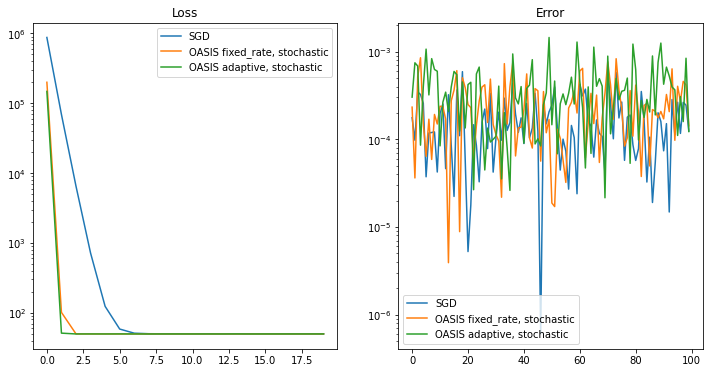

In [63]:
plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)
plt.semilogy(loss_sgd)
#plt.semilogy(loss_o)
plt.semilogy(loss_os)
#plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_sgd-x_gt))
#plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os-x_gt))
#plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa-x_gt))
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

Next:

* ~~Run the new OASIS algorithms on the old (deterministic one operator) toy problem~~
* ~~Implement the adaptive version of the stochastic OASIS~~
* ~~Add noise and rerun all the experiments~~
* In the stochastic toy problem case, also compare with CG (make the problem small enough so that we can do CG)
* ~~Implement some kind of warm up /estimation of $D_0$~~
* Run on CryoEM data